In [25]:
import pandas as pd
import xgboost as xgb

df = pd.read_csv("train.csv")
to_drop = ["physical_part_id", "message_timestamp"]
for c in df.columns:
    if df[c].isna().all():
        to_drop.append(c)
df = df.drop(columns=to_drop)
categorical_features = [c for c in df.columns if "sensor" not in c]
df = pd.get_dummies(df, columns=categorical_features).drop(columns=["status_NOK"])
df.head()


,s6_sensor0_millimeter_step1,s8_sensor0_millimeter_step1,s8_sensor1_millimeter_step1,s7_sensor0_newton_step1,s9_sensor0_kilonewton_step1,s7_sensor1_mikrometer_step1,s0_sensor0_kilonewton_step3,s2_sensor0_millimeter_step1,s9_sensor1_sekunden (zeit)_step1,s8_sensor2_millimeter_step1,...,weekday_Friday,weekday_Monday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,shift_Fruehschicht,shift_Nachtschicht,shift_Spaetschicht,status_OK
0,4606.469076,19.525688,374.198570,8858.706709,36.836737,28705.766208,NaN,18.009638,1056.249745,9.082543,...,False,False,True,False,False,False,False,True,False,True
1,5886.043819,17.540378,360.603884,8851.987083,36.836737,27013.209239,-53.537243,20.258647,1056.249745,8.421043,...,False,False,True,False,False,False,False,True,False,True
2,4606.469076,20.445584,371.689206,8856.466834,36.836737,33241.818888,NaN,18.686098,1056.249745,7.245728,...,False,False,True,False,False,False,False,True,False,True
3,4606.469076,20.822377,372.461318,8854.226959,36.836737,32564.796100,NaN,15.347726,1056.249745,7.593400,...,False,False,True,False,False,False,False,True,False,True
4,4606.469076,18.592800,373.371307,8851.987083,36.836737,32835.605215,NaN,21.242588,1056.249745,7.184193,...,False,False,True,False,False,False,False,True,False,True


In [26]:
# Take 20% of data for validation
df_train = df.sample(frac=0.8, random_state=42)
df_val = df.drop(df_train.index)

print(len(df_train), len(df_val))


35854 8964


In [27]:
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer

# Transform to X, y numpy arrays
X_train = df_train.drop(columns=["status_OK"]).values
y_train = df_train["status_OK"].values
X_val = df_val.drop(columns=["status_OK"]).values
y_val = df_val["status_OK"].values

# Impute NaN using mean (column-wise). Same imputer should be used for train and val
imputer = SimpleImputer(strategy="mean")
X_train = imputer.fit_transform(X_train)
X_val = imputer.transform(X_val)

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Train XGBoost on balanced data
tree = xgb.XGBRegressor()
tree.fit(X_train_balanced, y_train_balanced)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

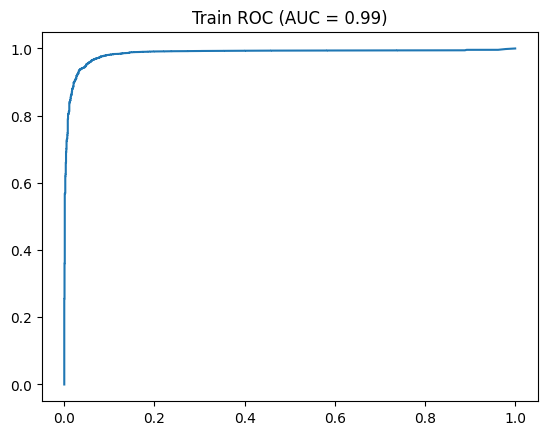

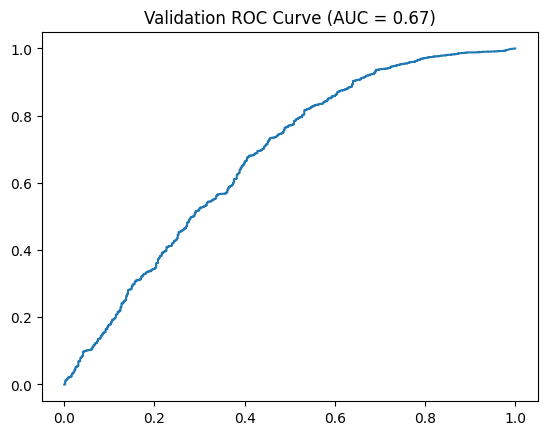

In [28]:
# Plot ROC curve on train
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve

y_pred = tree.predict(X_train)
fpr, tpr, thresholds = roc_curve(y_train, y_pred)
roc_auc = auc(fpr, tpr)
plt.title(f"Train ROC (AUC = {roc_auc:.2f})")
plt.plot(fpr, tpr)
plt.show()

y_pred = tree.predict(X_val)
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)
plt.title(f"Validation ROC Curve (AUC = {roc_auc:.2f})")
plt.plot(fpr, tpr)
plt.show()
